In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#imports
!pip install transformers
!pip install sumy
!pip install sentencepiece
!pip install bert-extractive-summarizer 
from transformers import T5Tokenizer, T5ForConditionalGeneration
import re
from __future__ import absolute_import
from __future__ import division, print_function, unicode_literals
import math
from sumy.summarizers import AbstractSummarizer
import numpy
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from absl import logging
from sklearn.cluster import KMeans
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from summarizer import TransformerSummarizer

In [3]:
data = pd.read_csv('/content/Tweets.csv')
data

,Tweet:
0,Pi goes a long way at \r\n@NASA\r\n. It is use...
1,While we're all in favor of a little extra pie...
2,Ready to take math to Mars and beyond on #PiD...
3,"Happy #PiDay! It’s March 14th, or 3.14 – also ..."
4,"When we look at a slice of the night sky, 𝞹 (o..."
5,"Pi takes us far in space exploration. In fact,..."
6,"""In May last year, I announced the creation of..."
7,"""When we launched the Solidarity Response Fund..."
8,"""The money collected will be used to suppress ..."
9,"""The plan calls for a total requirement of $1...."


Tweet:    Falcon 9’s first stage has landed on the Of Co...
Name: 23, dtype: object


In [4]:
#data preparation
data_nparray = np.array(data)
data_array = []
for tweet in data_nparray:
  data_array.append(tweet[0])

data_copy = data_array

In [5]:
final_data = []
for tweet in data_array:
  tweet = tweet.replace("@","")
  tweet = tweet.replace('"',"")
  tweet = tweet.replace("\n","")
  tweet = tweet.replace("#","")
  tweet = tweet.replace(":","")
  tweet = tweet.replace("...","")
  
  final_data.append(tweet)

In [6]:
#embedding data
emb_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.


In [7]:
embedded_final = emb_model(np.array(final_data))
embedded_final

pca = PCA(2)
embedded_final_new = pca.fit_transform(embedded_final)

In [8]:
#clustering
cluster_method = KMeans(3, random_state=1)

final_clusters = cluster_method.fit_predict(embedded_final_new)
final_clusters_unique = np.unique(final_clusters)

labels = cluster_method.labels_

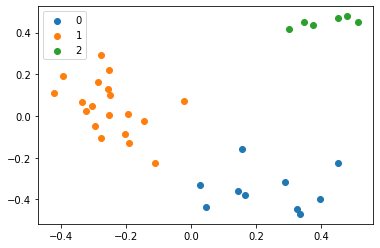

In [9]:
for i in final_clusters_unique:
  plt.scatter(embedded_final_new[final_clusters == i , 0] , embedded_final_new[final_clusters == i , 1] , label = i)
  
plt.legend()
plt.show()

In [10]:
#preparation for TextRank Summarization
final = []
for tweet in final_data:
  tweet = tweet.replace(" ","")
  final.append(tweet)

In [11]:
class TextRankSummarizer(AbstractSummarizer):
  epsilon = 1e-4
  damping = 0.85
  _delta = 1e-7 
  _stop_words = frozenset()

  @property
  def stop_words(self):
    return self._stop_words

  @stop_words.setter
  def stop_words(self, words):
    self._stop_words = frozenset(map(self.normalize_word, words))

  @stop_words.setter
  def stop_words(self, words):
    self._stop_words = frozenset(map(self.normalize_word, words))

  def __call__(self, document, sentences_count):
    self._ensure_dependencies_installed()
    if not document.sentences:
      return ()
 
    ratings = self.rate_sentences(document)
    return self._get_best_sentences(document.sentences, sentences_count, ratings)

  @staticmethod
  def _ensure_dependencies_installed():
    if numpy is None:
      raise ValueError("LexRank summarizer requires NumPy. Please, install it by command 'pip install numpy'.")


  def _create_matrix(self, document):
    sentences_as_words = [self._to_words_set(sent) for sent in document.sentences]
    sentences_count = len(sentences_as_words)
    weights = numpy.zeros((sentences_count, sentences_count))

    for i, words_i in enumerate(sentences_as_words):
      for j, words_j in enumerate(sentences_as_words):
        weights[i, j] = self._rate_sentences_edge(words_i, words_j)

    weights /= (weights.sum(axis=1)[:, numpy.newaxis]+self._delta) 
    return numpy.full((sentences_count, sentences_count), (1.-self.damping) / sentences_count) + self.damping * weights

  def _to_words_set(self, sentence):
    words = map(self.normalize_word, sentence.words)
    return [self.stem_word(w) for w in words if w not in self._stop_words]

  def rate_sentences(self, document):
    matrix = self._create_matrix(document)
    ranks = self.power_method(matrix, self.epsilon) 
    return {sent: rank for sent, rank in zip(document.sentences, ranks)}

  @staticmethod
  def power_method(matrix, epsilon):
    transposed_matrix = matrix.T
    sentences_count = len(matrix)
    p_vector = numpy.array([1.0 / sentences_count] * sentences_count)
    lambda_val = 1.0

    while lambda_val > epsilon:
      next_p = numpy.dot(transposed_matrix, p_vector)
      lambda_val = numpy.linalg.norm(numpy.subtract(next_p, p_vector))
      p_vector = next_p

    return p_vector

  @staticmethod
  def _rate_sentences_edge(words1, words2):
    rank = 0
    for w1 in words1:
      for w2 in words2:
        rank += int(w1 == w2)

      if rank == 0:
        return 0.0

      assert len(words1) > 0 and len(words2) > 0
      norm = math.log(len(words1)) + math.log(len(words2))
      if numpy.isclose(norm, 0.):
            # This should only happen when words1 and words2 only have a single word. Thus, rank can only be 0 or 1.
        assert rank in (0, 1)
        return rank * 1.0
      else:
        return rank / norm

In [12]:
#Ordinary rate sentences with TextRank
model_sm = TextRankSummarizer()

words1 = final_data[17].split(" ")
words2 = final_data[12].split(" ")

print(model_sm._rate_sentences_edge(words1, words2))

0.36926937306885504


In [119]:
#T5 summarization and rate sentences with TextRank
model = T5ForConditionalGeneration.from_pretrained('t5-base')
tokenizer = T5Tokenizer.from_pretrained('t5-base')

preprocessed_text1 = "summarize: "+final_data[17]
preprocessed_text2 = "summarize: "+final_data[12]

tokens_input1 = tokenizer.encode(preprocessed_text1, 
                                return_tensors="pt", 
                                max_length=512, 
                                truncation=True)
tokens_input2 = tokenizer.encode(preprocessed_text2, 
                                return_tensors="pt", 
                                max_length=512, 
                                truncation=True)

summary_ids1 = model.generate(tokens_input1,
                             min_length=8, 
                             max_length=512, 
                             length_penalty=4.0)
summary_ids2 = model.generate(tokens_input2,
                             min_length=8, 
                             max_length=512, 
                             length_penalty=4.0)

summary1 = tokenizer.decode(summary_ids1[0])
summary2 = tokenizer.decode(summary_ids2[0])

words1 = summary1.split(" ")
words2 = summary2.split(" ")

print(model_sm._rate_sentences_edge(words1, words2))

0.12595227380626867


In [107]:
#GTP2 summarization and rate sentences with TextRank
model = TransformerSummarizer(transformer_type="GPT2",
                              transformer_model_key="gpt2-medium")

summary1 = ''.join(model(final_data[17], min_length=8, max_length=512))
summary2 = ''.join(model(final_data[12], min_length=8, max_length=512))

words1 = summary1.split(" ")
words2 = summary2.split(" ")

print(model_sm._rate_sentences_edge(words1, words2))

Some weights of GPT2Model were not initialized from the model checkpoint at gpt2-medium and are newly initialized: ['h.2.attn.masked_bias', 'h.21.attn.masked_bias', 'h.6.attn.masked_bias', 'h.14.attn.masked_bias', 'h.20.attn.masked_bias', 'h.0.attn.masked_bias', 'h.19.attn.masked_bias', 'h.1.attn.masked_bias', 'h.11.attn.masked_bias', 'h.3.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.12.attn.masked_bias', 'h.23.attn.masked_bias', 'h.13.attn.masked_bias', 'h.5.attn.masked_bias', 'h.7.attn.masked_bias', 'h.22.attn.masked_bias', 'h.16.attn.masked_bias', 'h.17.attn.masked_bias', 'h.15.attn.masked_bias', 'h.18.attn.masked_bias', 'h.4.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.36926937306885504


In [108]:
#XLNet summarization and rate sentences with TextRank
model = TransformerSummarizer(transformer_type="XLNet",
                              transformer_model_key="xlnet-base-cased")

summary1 = ''.join(model(final_data[17], min_length=8, max_length=512))
summary2 = ''.join(model(final_data[12], min_length=8, max_length=512))

words1 = summary1.split(" ")
words2 = summary2.split(" ")

print(model_sm._rate_sentences_edge(words1, words2))

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0.36926937306885504


# roBERTa

In [109]:
from transformers import RobertaTokenizer, RobertaForCausalLM, RobertaConfig

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

config = RobertaConfig.from_pretrained("roberta-base")
config.is_decoder = True

model = RobertaForCausalLM.from_pretrained('roberta-base', config=config)

In [121]:
tokens1 = tokenizer.encode("summarize: "+final_data[17], return_tensors="pt" )
tokens2 = tokenizer.encode("summarize: "+final_data[12], return_tensors="pt")

summary1_ids = model.generate(tokens1, max_length=70, min_length=10, length_penalty=4.0, num_beams=2)
summary2_ids = model.generate(tokens2, max_length=70, min_length=10, length_penalty=4.0, num_beams=2)

In [122]:
summary1 = tokenizer.decode(summary1_ids[0])
summary2 = tokenizer.decode(summary2_ids[0])

words1 = summary1.split(" ")
words2 = summary2.split(" ")

print(model_sm._rate_sentences_edge(words1, words2))

0.143476331982022
